In [2]:
import numpy as np
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch import nn, optim
from torchsummary import summary
import torch.utils.data as data_utils


In [3]:
projectDevice = "cuda" if torch.cuda.is_available() else "cpu"
batchSize = 32
numEpochs = 10
learningRate = 0.01
inputSize = (1,28,28)

In [4]:
def process_x(x):
  x = x.type(torch.float32)

  # Normalize the data between [-1.0, 1.0]
  x /= 127.5
  x -= 1.0
  x = torch.unsqueeze(x, dim=1) # [NxHxW] -> [CxHxW] for PyTorch
  return x

def load_data(ds=torchvision.datasets.MNIST):
  training, test = ds('./data/mnist', download=True), ds('./data/mnist', download=True, train=False)
  train_images, train_labels = process_x(training.data), training.targets
  test_images, test_labels = process_x(test.data), test.targets

  return (train_images, train_labels), (test_images, test_labels)

In [5]:
(train_x, train_y), (test_x, test_y) = load_data()

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 6470562.25it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 8183738.27it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 6479831.16it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 4741296.36it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [6]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(CNN, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32,
                            kernel_size=3)
        self.conv_layer2 = nn.Conv2d(32, 64, 3)
        self.fc = nn.Linear(in_features= 64*5*5, out_features=10)

        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.batch_norm2 = nn.BatchNorm2d(64)

        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x.shape = BxCxHxW

        # Block 1
        out = self.conv_layer1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 2
        out = self.conv_layer2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)

        return out


In [7]:
def train_model(model, epochs, batchSize, device=projectDevice):
  model_history = {"loss":[], "sparse_categorical_accuracy": [],
                   "val_loss":[], "val_sparse_categorical_accuracy":[]}

  model.to(device)
  summary(model, input_size=inputSize, device=device)

  optimizer = optim.Adam(model.parameters(), lr=learningRate)
  criterion = nn.CrossEntropyLoss()

  train = data_utils.TensorDataset(train_x, train_y)
  train_loader = data_utils.DataLoader(train, batch_size=batchSize, shuffle=True)

  val = data_utils.TensorDataset(test_x, test_y)
  val_loader = data_utils.DataLoader(val, batch_size=batchSize, shuffle=False)

  for epoch in range(epochs):

    start = time.time()
    print(f'Epoch {epoch+1}')
    train_loss = 0.0
    train_correct = 0.0

    val_loss = 0.0
    val_correct = 0.0

    model.train()

    for data in tqdm(train_loader):

        x, y = data
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += outputs.shape[0] * loss.item()
        train_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    train_loss = train_loss/float(len(train_x))
    train_correct = train_correct/float(len(train_x))

    model_history["loss"].append(train_loss)
    model_history["sparse_categorical_accuracy"].append(train_correct)

    model.eval()
    with torch.no_grad():

      for data in val_loader:
          x, y = data
          x, y = x.to(device), y.to(device)

          outputs = model(x)
          loss = criterion(outputs, y)

          val_loss += outputs.shape[0] * loss.item()
          val_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    val_loss = val_loss/float(len(test_x))
    val_correct = val_correct/float(len(test_x))

    model_history["val_loss"].append(val_loss)
    model_history["val_sparse_categorical_accuracy"].append(val_correct)

    end = time.time()

    print(f"Time: {(end-start):.2f} s  - ",
          f"Loss: {train_loss:.4f}  -  Categorical_Accuracy: {train_correct:.4f}  - ",
          f"Val_Loss: {val_loss:.4f}  -  Categorical_Val_Accuracy: {val_correct:.4f}")

  print('Finished Training')

  return model, model_history

In [8]:
modelCNN = CNN()
modelCNN, modelCNNHistory = train_model(modelCNN, numEpochs, batchSize, projectDevice)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Linear: 1-3                            16,010
├─BatchNorm2d: 1-4                       64
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─BatchNorm2d: 1-7                       128
├─Flatten: 1-8                           --
├─Dropout: 1-9                           --
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
Epoch 1


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 20.64 s  -  Loss: 0.1592  -  Categorical_Accuracy: 0.9609  -  Val_Loss: 0.0520  -  Categorical_Val_Accuracy: 0.9834
Epoch 2


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 20.79 s  -  Loss: 0.0533  -  Categorical_Accuracy: 0.9833  -  Val_Loss: 0.0538  -  Categorical_Val_Accuracy: 0.9829
Epoch 3


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 23.19 s  -  Loss: 0.0454  -  Categorical_Accuracy: 0.9859  -  Val_Loss: 0.0351  -  Categorical_Val_Accuracy: 0.9885
Epoch 4


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.17 s  -  Loss: 0.0386  -  Categorical_Accuracy: 0.9880  -  Val_Loss: 0.0455  -  Categorical_Val_Accuracy: 0.9864
Epoch 5


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.15 s  -  Loss: 0.0348  -  Categorical_Accuracy: 0.9893  -  Val_Loss: 0.0330  -  Categorical_Val_Accuracy: 0.9902
Epoch 6


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 21.45 s  -  Loss: 0.0327  -  Categorical_Accuracy: 0.9898  -  Val_Loss: 0.0452  -  Categorical_Val_Accuracy: 0.9876
Epoch 7


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 21.87 s  -  Loss: 0.0264  -  Categorical_Accuracy: 0.9920  -  Val_Loss: 0.0438  -  Categorical_Val_Accuracy: 0.9882
Epoch 8


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 21.54 s  -  Loss: 0.0284  -  Categorical_Accuracy: 0.9915  -  Val_Loss: 0.0533  -  Categorical_Val_Accuracy: 0.9884
Epoch 9


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.13 s  -  Loss: 0.0256  -  Categorical_Accuracy: 0.9927  -  Val_Loss: 0.0603  -  Categorical_Val_Accuracy: 0.9859
Epoch 10


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 20.88 s  -  Loss: 0.0239  -  Categorical_Accuracy: 0.9933  -  Val_Loss: 0.0537  -  Categorical_Val_Accuracy: 0.9883
Finished Training


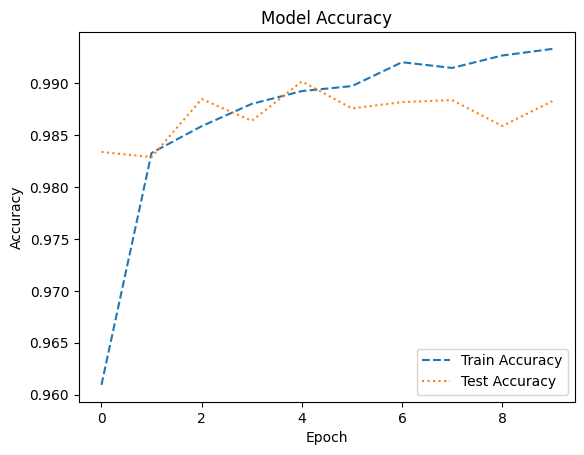

In [9]:
plt.plot(
    modelCNNHistory['sparse_categorical_accuracy'],
    linestyle='dashed')
plt.plot(
    modelCNNHistory['val_sparse_categorical_accuracy'],
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()

In [10]:
def modelEval(model, test_images, test_labels, device=projectDevice):

  num_correct = 0
  num_total = 0

  model.to(device)
  model.eval()

  average_time = 0

  pbar = tqdm(range(len(test_images)), total=len(test_images), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar

  with torch.no_grad():
    for idx in pbar:
      start = time.time()
      num_total = num_total + 1

      input = test_images[idx:idx+1].to(device)

      output = model(input)

      if output.argmax(1) == test_labels[idx]:
        num_correct = num_correct + 1
      end = time.time()

      average_time += end-start

      pbar.set_description(f'Test Image {idx+1} Eval time: {end-start:.10f}s', refresh=False)
  print('Average time per image:', average_time/len(test_images))
  print('Accuracy:', num_correct * 1.0 / num_total)

In [11]:
start = time.time()
modelEval(modelCNN, test_x, test_y, projectDevice)
end = time.time()
print(f'Eval time: {end-start:.2f}s')

  0%|          | 0/10000 [00:00<?, ?it/s]

Average time per image: 0.00029183287620544436
Accuracy: 0.9883
Eval time: 3.00s
